In [9]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
%matplotlib inline

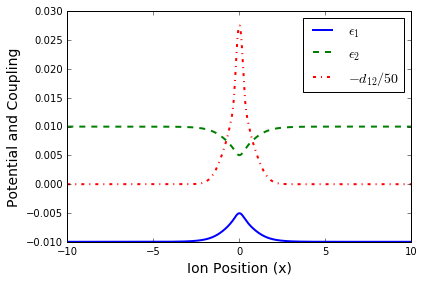

In [10]:
# load data
data_folder = "./data/"
xgrid_data,e1_data = np.loadtxt(data_folder+"Tully-model1-e1.dat").T
xgrid_data,e2_data = np.loadtxt(data_folder+"Tully-model1-e2.dat").T
xgrid_data,d12_data = np.loadtxt(data_folder+"Tully-model1-d12.dat").T

# interpolate
e1fit  = interp.splrep(xgrid_data,e1_data)
e2fit  = interp.splrep(xgrid_data,e2_data)
d12fit = interp.splrep(xgrid_data,d12_data)

e1 = lambda x: interp.splev(x,e1fit)
e2 = lambda x: interp.splev(x,e2fit)
d12 = lambda x: interp.splev(x,d12fit)

# check splines
pos_min = -10.0
pos_max = 10.0

xfine = np.linspace(-10,10,1000)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
#plt.savefig("single.eps")

In [11]:
# calculate forces on surfaces
e1der = lambda x: interp.splev(x, interp.splder(e1fit,1) )
e2der = lambda x: interp.splev(x, interp.splder(e2fit,1) )

In [12]:
# !! zoom in to avoid spline edge
pos_min /= 2.
pos_max /= 2.

In [13]:
def run1(x0,v0,c1,nstep,dt=0.1,m=2000.):

    hbar = 1.0
    
    # initialize electronic state
    c2 = np.sqrt(1.-c1*c1)
    a11 = c1*np.conj(c1)
    a12 = c1*np.conj(c2)
    a21 = np.conj(a12)
    a22 = c2*np.conj(c2)

    # initialize ion
    pos = x0
    vel = v0

    # make room for scalar quantities
    pos_trace = np.zeros(nstep)
    vel_trace = np.zeros(nstep)
    a11_trace  = np.zeros(nstep)
    a22_trace  = np.zeros(nstep)
    energy_trace = np.zeros(nstep)
    pot_trace = np.zeros(nstep)
    prob_trace = np.zeros(nstep)

    on_surface1 = True
    surface = e1
    surface_der = e1der
    switch_prob = 0.0

    for t in range(nstep):

        # record scalar quantities
        pos_trace[t] = pos
        vel_trace[t] = vel
        pot_trace[t] = surface(pos)
        energy_trace[t] = 0.5*m*vel*vel + surface(pos)
        
        a11_trace[t] = a11.real
        a22_trace[t] = a22.real
        prob_trace[t] = switch_prob.real

        # propagate electronic state forward
        c1 += dt*(c1*e1(pos)/(1j*hbar) - c2*vel*d12(pos))
        c2 += dt*(c2*e2(pos)/(1j*hbar) + c1*vel*d12(pos))

        # find new electronic state and change rate
        a11 = c1*np.conj(c1)
        a12 = c1*np.conj(c2)
        a21 = np.conj(a12)
        a22 = c2*np.conj(c2)

        b12 = -2.*(np.conj(a12)*vel*d12(pos)).real
        b21 =  2.*(np.conj(a21)*vel*d12(pos)).real
        
        # calculate hop probability
        if on_surface1:
            #switch_prob = dt*b21/a11
            switch_prob = dt*b12/a11
        else:
            #switch_prob = dt*b12/a22
            switch_prob = dt*b21/a11
        # end if

        # decide hopping
        hopped = False
        if switch_prob.real > np.random.rand():
            
            new_kinetic = 0.0
            # check kinetic energy
            cur_energy = energy_trace[t]
            if on_surface1:
                new_kinetic = cur_energy - e2(pos)
            else:
                new_kinetic = cur_energy - e1(pos)
            # end if

            if new_kinetic < 0:
                hopped = False
            else:
                hopped = True
            # end if

            # switch surface if decide to hop
            if hopped:

                if on_surface1:
                    surface = e2
                    surface_der = e2der
                else:
                    surface = e1
                    surface_der = e1der
                # end if
                on_surface1 = not on_surface1

                # adjust velocity
                vel = np.sign(vel) * np.sqrt(2.*new_kinetic/m)

            # end if hopped

        # end if switch_prob > rand()

        # propagate ion forward
        a0 = -surface_der(pos)/m
        pos += vel*dt + 0.5*a0*dt*dt
        a1 = -surface_der(pos)/m
        vel += 0.5*(a0+a1)*dt
        
        # break when ion moves outside of scattering region
        if pos >= pos_max or pos <= pos_min:
            break
        # end if

    # end for t
    
    transmission = False
    reflection   = False
    if (pos >= pos_max):
        transmission = True
    # end if
    elif (pos <= pos_min):
        reflection = True
    # end if
    
    return pos_trace[:t],vel_trace[:t],pot_trace[:t],energy_trace[:t]\
,a11_trace[:t],a22_trace[:t],t\
,on_surface1,transmission,reflection,prob_trace[:t]
# end def 

In [14]:
# play with one trajectory
#ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
#,on1,trans,ref,prob_trace = run1(-5.0,8.9/2000.,1.0,10000,dt=2.0)

In [15]:
# production
klist = [2.5,4.5,10,15,20,25,30,35]
ntrans1 = np.zeros(len(klist))
ntrans2 = np.zeros(len(klist))
nref1   = np.zeros(len(klist))
nref2   = np.zeros(len(klist))
not_finished = np.zeros(len(klist))

ntraj = 200
for i in range(len(klist)):
    k = klist[i]
    for j in range(ntraj):
        vo = k/2000.
        ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
,on1,trans,ref,prob_trace = run1(-5.0,vo,1.0,4000,dt=2.0)

        if on1 and trans:
            ntrans1[i] += 1
        # end if
        if on1 and ref:
            nref1[i] += 1
        # end if
        
        if (not on1) and trans:
            ntrans2[i] += 1
        # end if
        if (not on1) and ref:
            nref2[i] += 1
        # end if
        
        if (not trans) and (not ref):
            not_finished[i] += 1
        # end if
        
    # end for j
# end for i

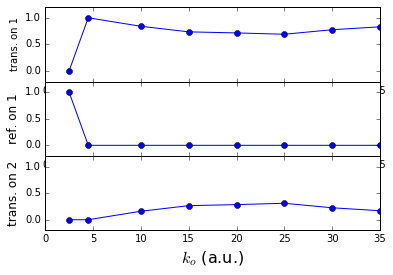

In [16]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.001)

ax  = fig.add_subplot(311)


ax.set_yticks([0,0.5,1])
ax.set_ylim(-0.2,1.2)
ax.plot(klist,ntrans1/ntraj,"o-")
ax.set_ylabel("trans. on 1")

ax1 = fig.add_subplot(312,sharex=ax)
ax1.set_yticks([0,0.5,1])
ax1.set_ylim(-0.2,1.2)
ax1.plot(klist,nref1/ntraj,"o-")
ax1.set_ylabel("ref. on 1",fontsize=12)

ax2 = fig.add_subplot(313,sharex=ax)
ax2.set_yticks([0,0.5,1])
ax2.set_ylim(-0.2,1.2)
ax2.plot(klist,ntrans2/ntraj,"o-")
ax2.set_ylabel("trans. on 2",fontsize=12)
ax2.set_xlabel("$k_o$ (a.u.)",fontsize=16)
#plt.savefig("model-1-prob.eps")